# Correlating mobility and drop in energy demand

This file correlates mobility to the calculated impact of lockdown on energy demand.

Good correlation would indicate that the data extracted from the energy data corresponds to an impact of the lockdown.

In [1]:
# Single include needed
import brsflufight_nerc2 as bff2

## Data extraction

In [2]:
data_sets = bff2.load_data_files()

country = 'United Kingdom'
d_uk = data_sets.get_country(country)

A loading function must be defined in `data_access.default_file_read_functions`.
Success: historical_GHG_Sectors_GCP
Success: historical_GHG_Sectors_PIK
Success: historical_GHG_Sectors_UNFCCC
Success: mobility_apple
Failed: United Kingdom not in mobility_citymapper
Success: mobility_google
Success: uk_energy_daily
Success: uk_energy_demand_reduction


## Data recombination

In [3]:
# Data recombination
d_uk['uk_energy_yearly'] = bff2.summarise_to_freq(
    d_uk['uk_energy_daily'],
    freq='1Y', 
    fun_test_data=lambda gr: gr.count()["dayofyear"]>350,
)
d_uk['uk_energy_demand_reduction_yearly'] = bff2.summarise_to_freq(
    d_uk['uk_energy_demand_reduction'], freq='1Y', fun_test_data=None
)

d_uk['historical_GHG_Sectors_GCP']['Gas and Coal (CO2)'] = \
    d_uk['historical_GHG_Sectors_GCP']['Gas (CO2)'] \
    + d_uk['historical_GHG_Sectors_GCP']['Coal (CO2)']


## Correlation

In [4]:
to_correlate = {
    'uk_energy_yearly': ['oil', 'ccgt', 'coal', 'demand'],  # Carbon power generation
    'historical_GHG_Sectors_GCP': [  # Select only CO2 data not other gases
        s for s in d_uk['historical_GHG_Sectors_GCP'].columns if f"(CO2)" in s
    ],
    'historical_GHG_Sectors_PIK': [  # Select Energy data not other sectors
        'Energy (KYOTOGHG)', 'Energy (CO2)', 'Energy (N2O)', 'Energy (CH4)'
    ],
}

correlation_dict = bff2.correlate(
    selector=to_correlate,  # datasets defined above
    data_sets=d_uk,  # UK data
    main_compare='uk_energy_yearly',  # reference dataset, the other are correlated to it
)

bff2.display_correlations(correlation_dict, display_fun=display)

Linear regression failed for: 'Bunkers (CO2)' fit to  'oil':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').
Linear regression failed for: 'Bunkers (CO2)' fit to  'ccgt':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').
Linear regression failed for: 'Bunkers (CO2)' fit to  'coal':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').
Linear regression failed for: 'Bunkers (CO2)' fit to  'demand':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').
Pearson correlation coefficients in dataset 'historical_GHG_Sectors_GCP'
	 on data from 2012 to 2018 (inclusive)
_________________________________________________________


,Bunkers (CO2),Cement (CO2),Coal (CO2),Gas (CO2),Gas flaring (CO2),Oil (CO2),Total fossil fuels and cement (CO2),Gas and Coal (CO2)
oil,nan,-0.845,0.883,-0.613,-0.700,-0.883,0.883,0.883
ccgt,nan,0.739,-0.786,0.643,0.487,0.857,-0.786,-0.786
coal,nan,-0.703,1.000,-0.571,-0.775,-0.786,1.000,1.000
demand,nan,-0.703,1.000,-0.571,-0.775,-0.786,1.000,1.000



Pearson correlation coefficients in dataset 'historical_GHG_Sectors_PIK'
	 on data from 2012 to 2017 (inclusive)
_________________________________________________________


,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4)
oil,0.986,0.986,0.812,0.986
ccgt,-0.829,-0.829,-0.829,-0.886
coal,1.000,1.000,0.771,0.943
demand,1.000,1.000,0.771,0.943


## Prediction

In [5]:
prediction, change_corona = bff2.predict_correlation_model(
    d_uk['uk_energy_demand_reduction_yearly'],
    correlation_dict['historical_GHG_Sectors_PIK'],
)

display(change_corona)

,predictor_value,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4),quantity
date,,,,,,
2020-01-01,-3741.930094,-76.637021,-74.360175,-0.094797,-1.903151,absolute difference
2020-01-01,-0.117657,-0.199307,-0.198163,-0.037639,-0.273903,relative difference


## Model instant demand recovery on 01/07/2020

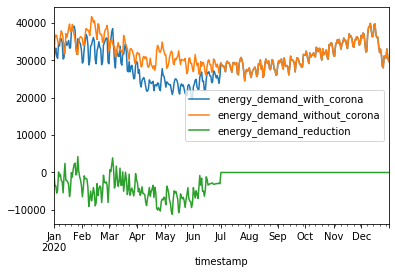

In [6]:
scenario2 = 'uk_energy_demand_reduction_scenario_instant_recovery'
d_uk[scenario2] = d_uk['uk_energy_demand_reduction']
july_mask = d_uk[scenario2].index >= "2020-07"
d_uk[scenario2].loc[july_mask,'energy_demand_with_corona'] = d_uk[scenario2].loc[july_mask,'energy_demand_without_corona']
d_uk[scenario2]['energy_demand_reduction'] = d_uk[scenario2]['energy_demand_with_corona']-d_uk[scenario2]['energy_demand_without_corona']
d_uk[scenario2].plot(y=data_sets['uk_energy_demand_reduction'].data_columns)

In [7]:
d_uk[scenario2 + '_yearly'] = bff2.summarise_to_freq(
    d_uk[scenario2], freq='1Y', fun_test_data=None
)

In [8]:
prediction_2, change_corona_2 = bff2.predict_correlation_model(
    d_uk[scenario2 + '_yearly'],
    correlation_dict['historical_GHG_Sectors_PIK'],
)

display(change_corona_2)

,predictor_value,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4),quantity
date,,,,,,
2020-01-01,-2113.183277,-43.279288,-41.993483,-0.053535,-1.074768,absolute difference
2020-01-01,-0.066444,-0.112555,-0.111909,-0.021256,-0.154681,relative difference
